In [1]:
import pandas as pd
import numpy as np
from pathlib import Path


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from warnings import simplefilter
simplefilter("ignore")

# Loading the data

In [3]:
dataset = pd.read_csv('refrigerator.csv', index_col = 'dteday', parse_dates = True)

Set the frequency

In [4]:
dataset = dataset.asfreq('M')
dataset.index

DatetimeIndex(['2012-01-31', '2012-02-29', '2012-03-31', '2012-04-30',
               '2012-05-31', '2012-06-30', '2012-07-31', '2012-08-31',
               '2012-09-30', '2012-10-31',
               ...
               '2023-04-30', '2023-05-31', '2023-06-30', '2023-07-31',
               '2023-08-31', '2023-09-30', '2023-10-31', '2023-11-30',
               '2023-12-31', '2024-01-31'],
              dtype='datetime64[ns]', name='dteday', length=145, freq='M')

# Visualization

<Axes: xlabel='dteday'>

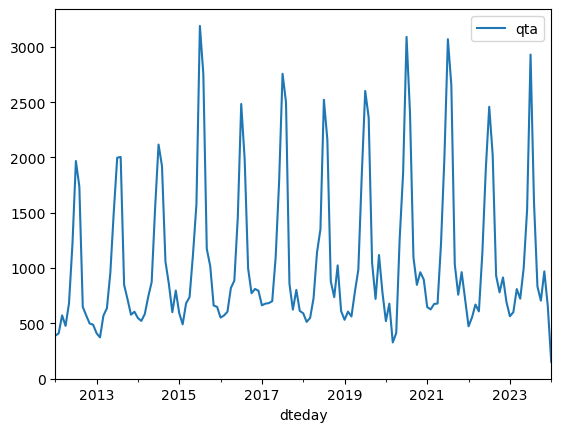

In [6]:
dataset['qta'].plot(legend=True)

# Data Transformation

Create a train and a test set based on the last year observation

In [7]:
test_days = 12
train_set = dataset.iloc[:-test_days,:]
test_set =  dataset.iloc[-test_days:,:]

<Axes: xlabel='dteday'>

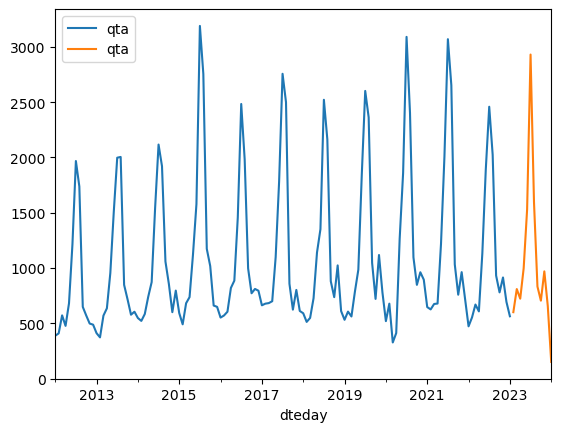

In [8]:
train_set['qta'].plot(legend=True)
test_set['qta'].plot(legend=True)

Testing the null hypothesis with the Augmendet Dickey–Fuller test

In [9]:
#Stationarity
from statsmodels.tsa.stattools import adfuller

stationarity = adfuller(dataset['qta'])
print ('Augmented Dickey-Fuller p-value %f' % stationarity[1])

Augmented Dickey-Fuller p-value 0.050140


Plot a periodogram of the dataset

In [11]:
import matplotlib.pyplot as plt


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax



<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

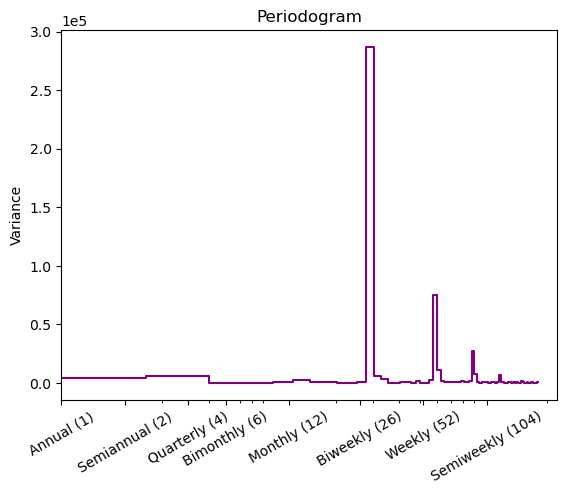

In [12]:
plot_periodogram(dataset.qta)

# CalendarFourier

In [13]:


fourier = CalendarFourier(freq="A", order=10)  # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=dataset.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()  # create features for dates in tunnel.index



In [14]:
X.head()

,const,trend,"s(2,12)","s(3,12)","s(4,12)","s(5,12)","s(6,12)","s(7,12)","s(8,12)","s(9,12)",...,"sin(2,freq=A-DEC)","cos(2,freq=A-DEC)","sin(3,freq=A-DEC)","cos(3,freq=A-DEC)","sin(4,freq=A-DEC)","cos(4,freq=A-DEC)","sin(5,freq=A-DEC)","cos(5,freq=A-DEC)","sin(6,freq=A-DEC)","cos(6,freq=A-DEC)"
dteday,,,,,,,,,,,,,,,,,,,,,
2012-01-31,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.857315,0.514793,0.999668,0.025748,0.882679,-0.469977,0.536696,-0.843776,0.051479,-0.998674
2012-02-29,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.898292,-0.439400,0.102821,-0.994700,-0.789418,-0.613856,-0.938710,0.344707,-0.204552,0.978856
2012-03-31,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.051479,-0.998674,-0.997018,-0.077175,-0.102821,0.994700,0.991723,0.128398,0.153891,-0.988088
2012-04-30,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.829677,-0.558244,-0.102821,0.994700,0.926324,-0.376728,-0.767880,-0.640593,-0.204552,0.978856
2012-05-31,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.890617,0.454755,0.997018,0.077175,-0.810025,-0.586396,0.384665,0.923056,0.153891,-0.988088


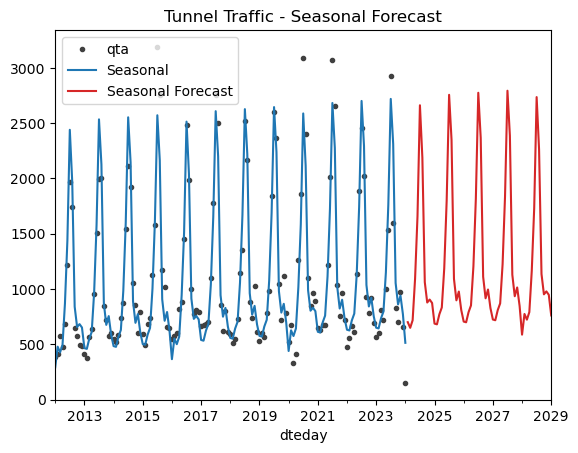

In [15]:
y = dataset['qta']

model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=60)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title="Tunnel Traffic - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

# Model assesment

In [17]:
#MAE and RMSE
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(round(mean_absolute_error(y, y_pred),0))
print(round(np.sqrt(mean_squared_error(y, y_pred)), 0))

134.0
186.0
